# Assessing carbon intensity of e-fuels:
## *a python tool making use of ENTSO-E retrospective time-series of electricity mix*

Romain Besseau*, Anne Bouter, Oliver Hurtig, Vincenzo Motola, Nicolae Scarlat.

European Commission, Joint Research Center (JRC), Ispra, Italy

*Corresponding author: romain.besseau@ec.europa.eu

This jupyter notebook contain all the code to transparently produce, and reproduce, the results of the published scientific work.

In [2]:
# extension for automatic code formating
%load_ext jupyter_black
# extension for reloading libraries (very useful when code under development)
%reload_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [3]:
# Import of libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys, os
import pycountry
import pyprind
import scipy

plt.style.use("ggplot")

In [4]:
import ecodynelec.neighbours
import ecodynelec.energy_grouping
import ecodynelec.visualisation as viz
from ecodynelec.ecodynelec import EcoDynElec_xr
from ecodynelec.statistics_LF import *

In [5]:
# Init the library, this step creates the required folders
ede = EcoDynElec_xr(year=2023)

# 1. Data download

**The first step consist in downloading the data:**
 
This can be done manually or using the ecodynelec library as done in the code below. More informations can be found [here](https://github.com/ElsevierSoftwareX/SOFTX-D-23-00240/blob/main/examples/downloading.ipynb).


For the downloading step, the user may need to adjust the dates, and specify their login and password.
If not already done, the user needs to register on the [ENSTO-E website](https://transparency.entsoe.eu/dashboard/show).

Please note that some companies firewall do not allows SFTP (Secure File Transfert Protocol).

In [6]:
config = ede.set_download_config()

The download takes a bit of time (it took me 1h30 for one year). The amount of data to download is quite important, but also the data are containted in files that also contains other data, that we will filter later on.

In [7]:
ede.download_ENTSOE_data(force=False)

Data were not download or redownloaded because they already exists. You have to specify 'force = True' if you want to redonwload them.


# 2. Data Formating

**The second step consist of formatting the data:**

As said before, the data are contained in heavy csv files, and those files are so heavy because they contain many other data that the one we need. In this notebook, we propose to extract and save the data in nicely structured and labeled xarray dataset. Then data can be loaded much faster than from the csv.

In [8]:
ede.get_generation_data()

<xarray.Dataset>
Dimensions:                 (Countries: 35, Energies: 20, DateTime: 8760)
Coordinates:
  * Countries               (Countries) <U2 'AT' 'BA' 'BE' ... 'SI' 'SK' 'XK'
  * Energies                (Energies) <U31 'Biomass' ... 'Wind Onshore'
  * DateTime                (DateTime) datetime64[ns] 2023-01-01 ... 2023-12-...
Data variables:
    ActualConsumption       (DateTime, Countries, Energies) float64 ...
    ActualGenerationOutput  (DateTime, Countries, Energies) float64 ...
    ActualNetGeneration     (DateTime, Countries, Energies) float64 240.0 ......

In [9]:
ede.get_exchange_data()

<xarray.Dataset>
Dimensions:              (Importing_Countries: 43, Exporting_Countries: 43,
                          DateTime: 8760)
Coordinates:
  * Importing_Countries  (Importing_Countries) <U2 'AL' 'AM' 'AT' ... 'UA' 'XK'
  * Exporting_Countries  (Exporting_Countries) <U2 'AL' 'AM' 'AT' ... 'UA' 'XK'
  * DateTime             (DateTime) datetime64[ns] 2023-01-01 ... 2023-12-31T...
Data variables:
    FlowValue            (DateTime, Importing_Countries, Exporting_Countries) float64 ...

# 3. Data Cleaning

In [10]:
import seaborn as sns

In [11]:
ede.set_download_config()
ede.get_generation_data()
ede.get_exchange_data()

<xarray.Dataset>
Dimensions:              (Importing_Countries: 43, Exporting_Countries: 43,
                          DateTime: 8760)
Coordinates:
  * Importing_Countries  (Importing_Countries) <U2 'AL' 'AM' 'AT' ... 'UA' 'XK'
  * Exporting_Countries  (Exporting_Countries) <U2 'AL' 'AM' 'AT' ... 'UA' 'XK'
  * DateTime             (DateTime) datetime64[ns] 2023-01-01 ... 2023-12-31T...
Data variables:
    FlowValue            (DateTime, Importing_Countries, Exporting_Countries) float64 ...

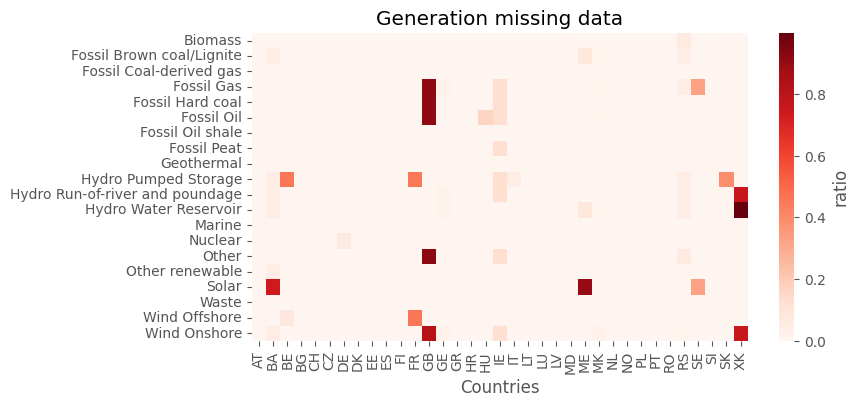

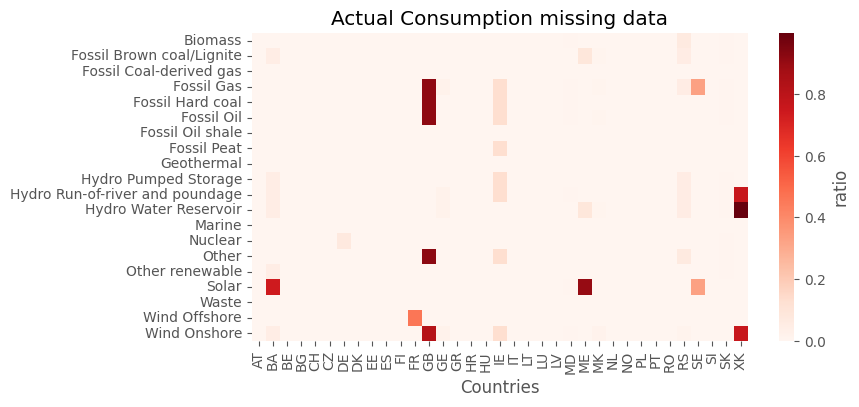

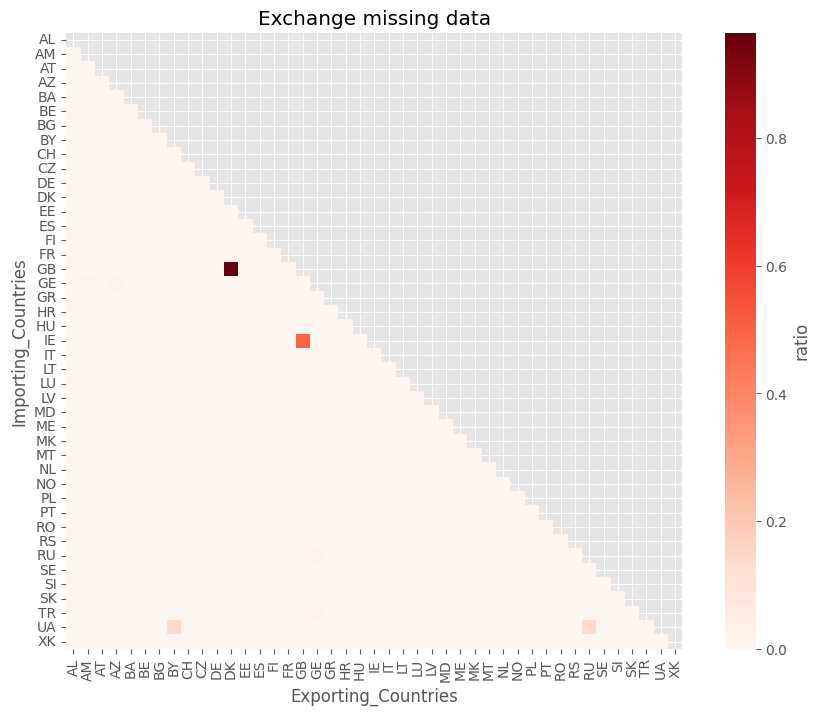

In [12]:
# Analysing missing data occurencies
df = ede.ds_generation.to_dataframe().unstack([0, 1]).isna().sum().unstack(2) / 8760
df = df.replace(0, np.nan).replace(1, np.nan)

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(
    data=df.loc["ActualGenerationOutput"].T.replace(np.nan, 0),
    ax=ax,
    cmap="Reds",
    cbar_kws={"label": "ratio"},
    vmin=0,
    xticklabels=True,
    yticklabels=True,
)
ax.set_title("Generation missing data")
ax.set_ylabel("")
plt.savefig("plot/missing_generation_data.png")

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(
    data=df.loc["ActualConsumption"].T.replace(np.nan, 0),
    ax=ax,
    cmap="Reds",
    cbar_kws={"label": "ratio"},
    vmin=0,
    xticklabels=True,
    yticklabels=True,
)
ax.set_title("Actual Consumption missing data")
ax.set_ylabel("")

df = (
    ede.ds_exchange.to_dataframe().FlowValue.unstack([0, 1]).isna().sum().unstack()
    / 8760
)
df = df.replace(0, np.nan).replace(1, np.nan)

mask = np.triu(df)
fig, ax = plt.subplots(figsize=(11, 8))
sns.heatmap(
    data=df.replace(np.nan, 0),
    ax=ax,
    cmap="Reds",
    cbar_kws={"label": "ratio"},
    vmin=0,
    xticklabels=True,
    yticklabels=True,
    mask=mask,
    square=True,
)
ax.set_title("Exchange missing data")
plt.savefig("plot/missing_exchange_data.png", bbox_inches="tight")

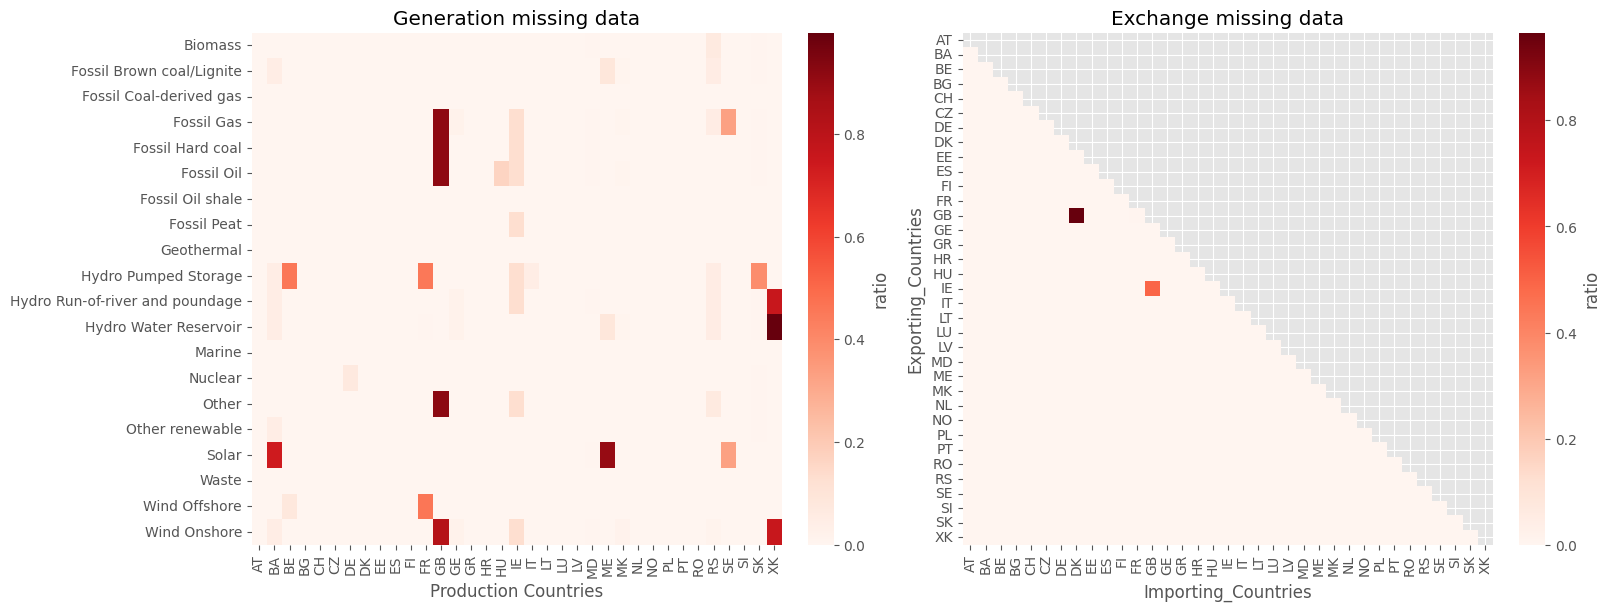

In [13]:
# Analysing missing data occurencies
df = ede.ds_generation.to_dataframe().unstack([0, 1]).isna().sum().unstack(2) / 8760
df = df.replace(0, np.nan).replace(1, np.nan)

# fig, ax = plt.subplots(2,1, figsize=(12, 4))
fig = plt.figure(layout="constrained", figsize=(16, 6))
ax = fig.subplot_mosaic("AB")

sns.heatmap(
    data=df.loc["ActualGenerationOutput"].T.replace(np.nan, 0),
    ax=ax["A"],
    cmap="Reds",
    cbar_kws={"label": "ratio"},
    vmin=0,
    xticklabels=True,
    yticklabels=True,
)
ax["A"].set_title("Generation missing data")
ax["A"].set_ylabel("")
ax["A"].set_xlabel("Production Countries")
# plt.savefig("plot/missing_generation_data.png")

df = (
    ede.ds_exchange.to_dataframe().FlowValue.unstack([0, 1]).isna().sum().unstack()
    / 8760
)
df = df.replace(0, np.nan).replace(1, np.nan)
df = df.loc[ede.ds_generation.Countries.values][ede.ds_generation.Countries.values]

mask = np.triu(df)
sns.heatmap(
    data=df.replace(np.nan, 0).T,
    ax=ax["B"],
    cmap="Reds",
    cbar_kws={"label": "ratio"},
    vmin=0,
    xticklabels=True,
    yticklabels=True,
    mask=mask,
    # square=True,
)
ax["B"].set_title("Exchange missing data")
plt.savefig("plot/missing_data.png", bbox_inches="tight")

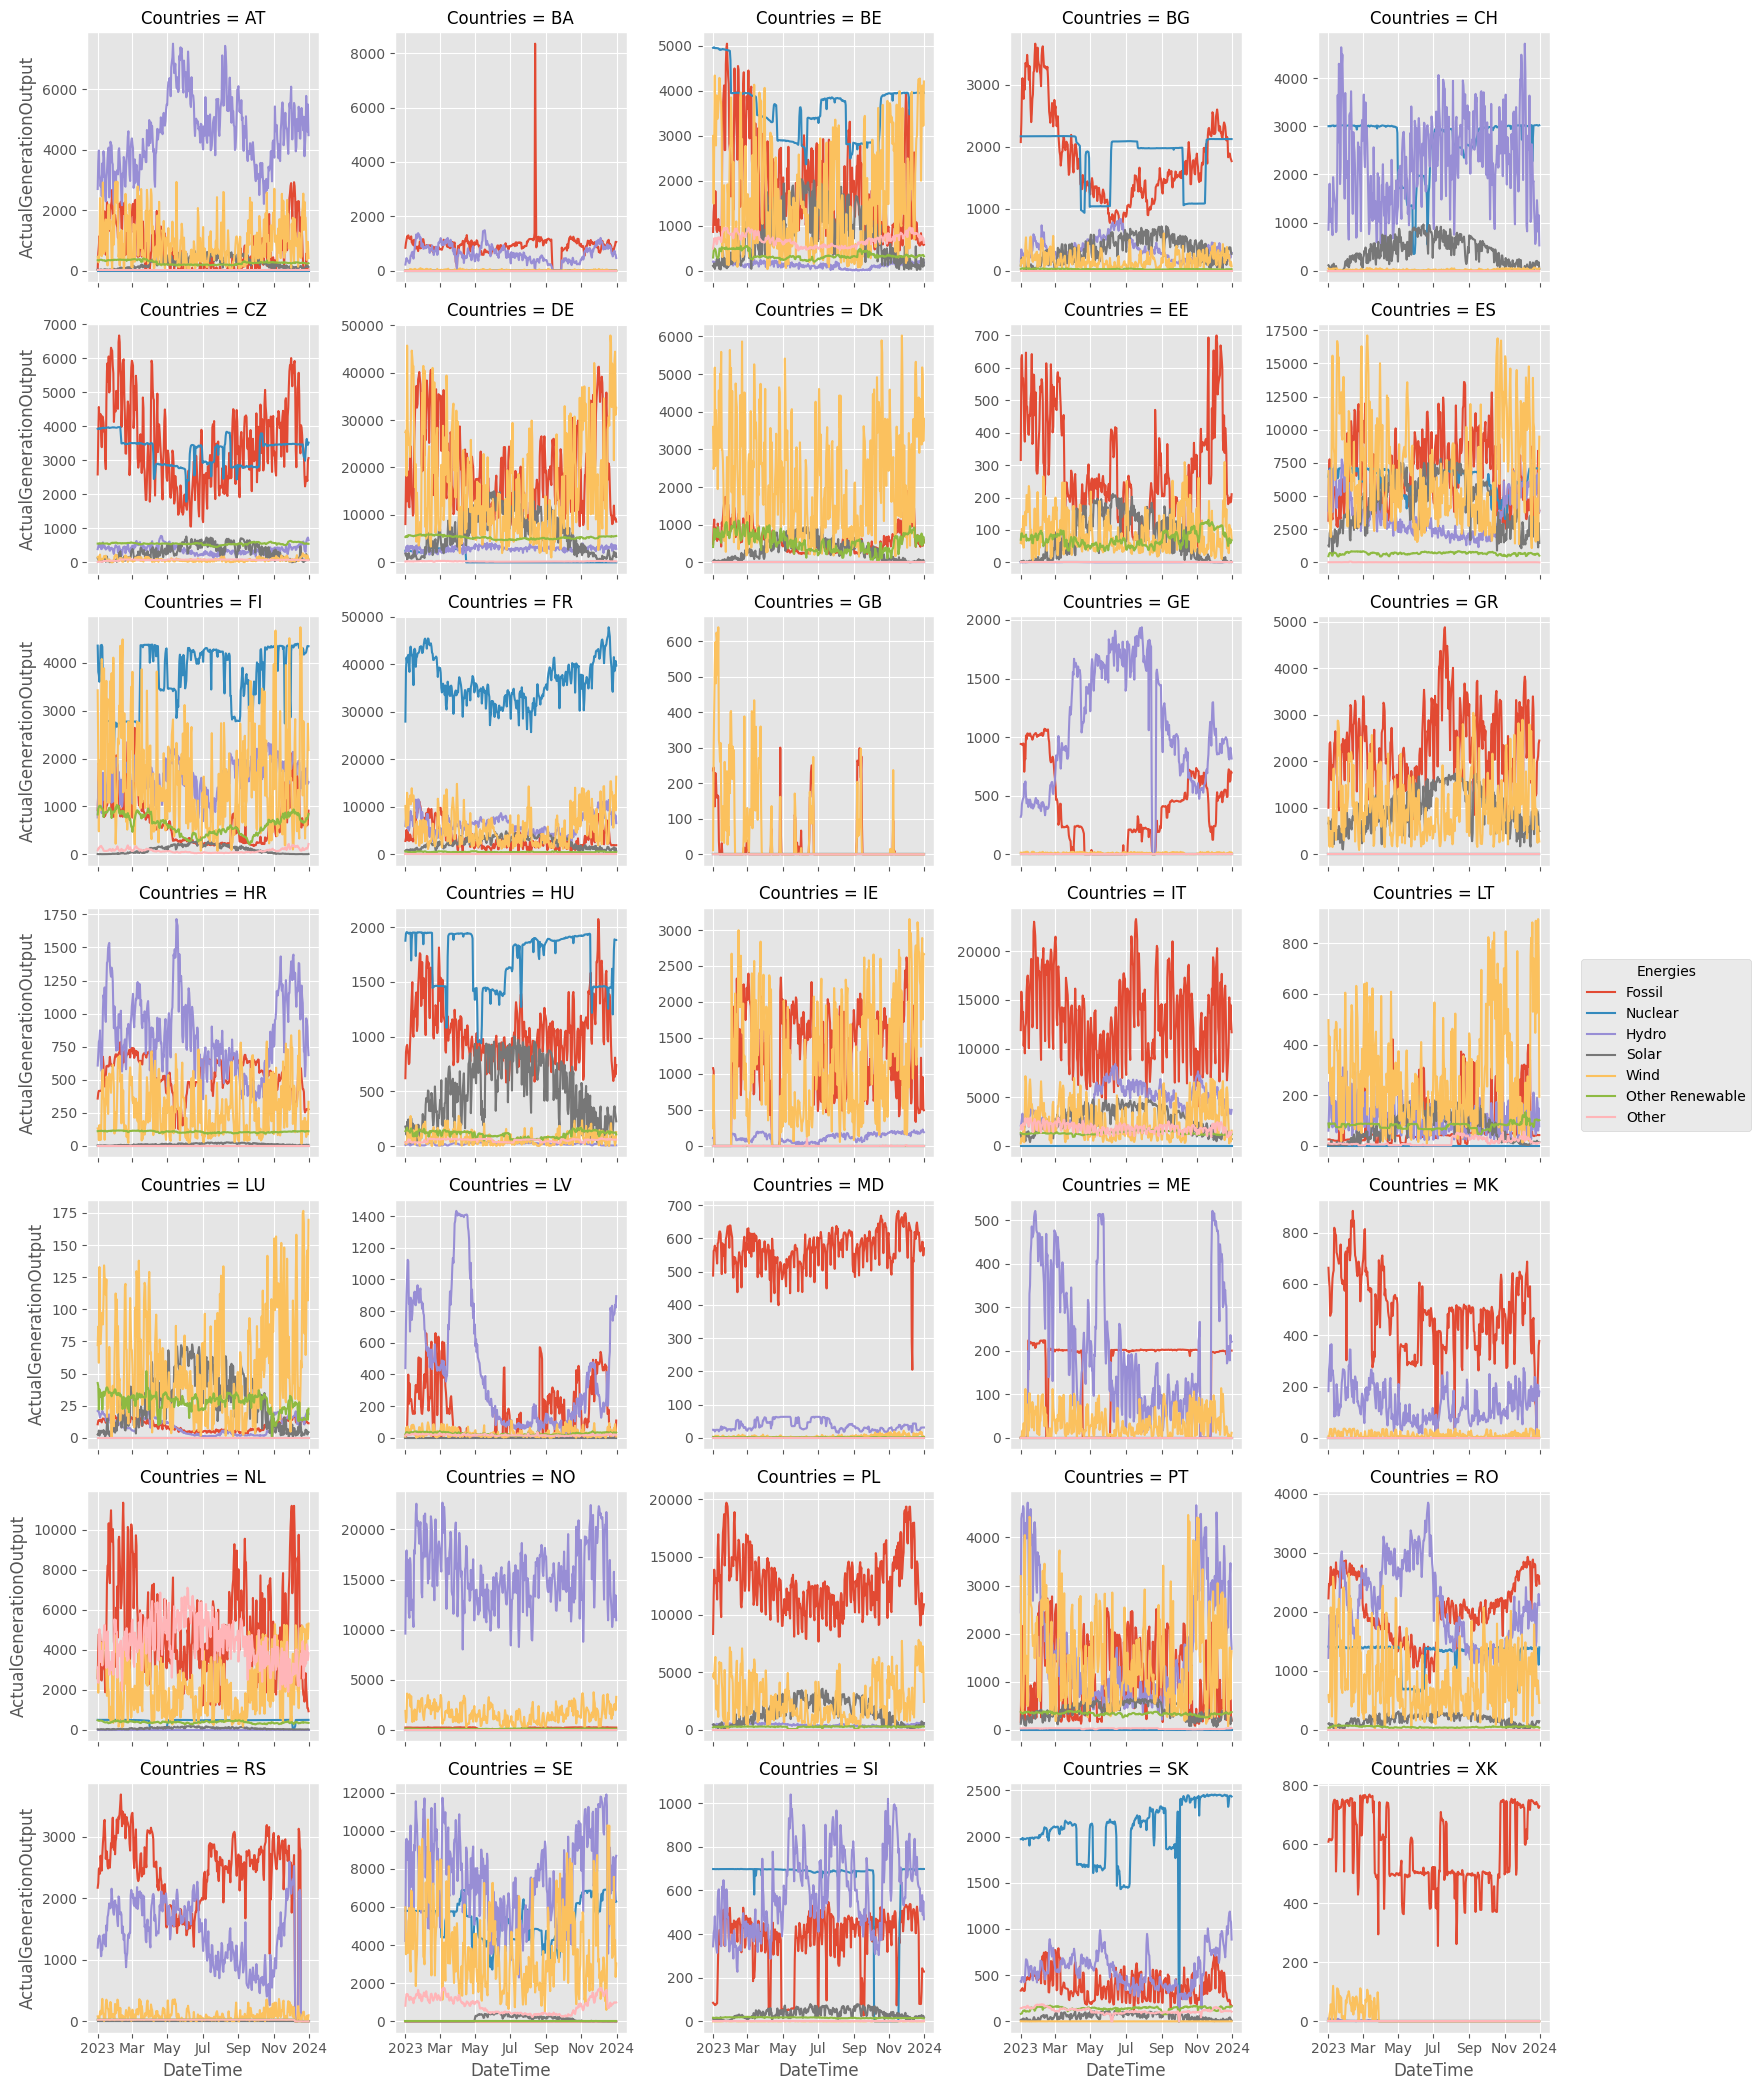

In [14]:
fig = (
    ede.ds_generation_grouped.resample(DateTime="D")
    .mean()
    .ActualGenerationOutput.plot(
        hue="Energies", col="Countries", col_wrap=5, sharey=False
    )
)
plt.savefig("plot/generation_time_series.png", bbox_inches="tight")

Text(0.5, 1.0, 'Wind offshore production in France')

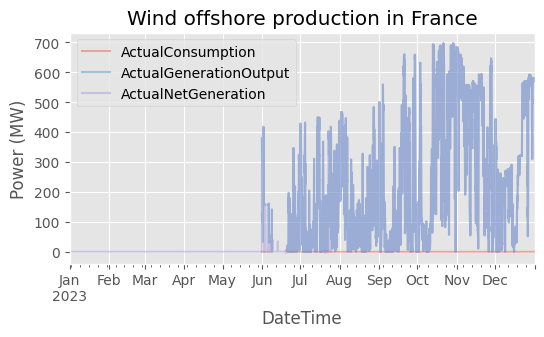

In [15]:
fig, ax = plt.subplots(figsize=(6, 3))
ede.ds_generation.sel(Countries="FR").sel(Energies="Wind Offshore").to_dataframe().drop(
    ["Countries", "Energies"], axis=1
).plot(alpha=0.4, ax=ax)
ax.set_ylabel("Power (MW)")
ax.set_title("Wind offshore production in France")

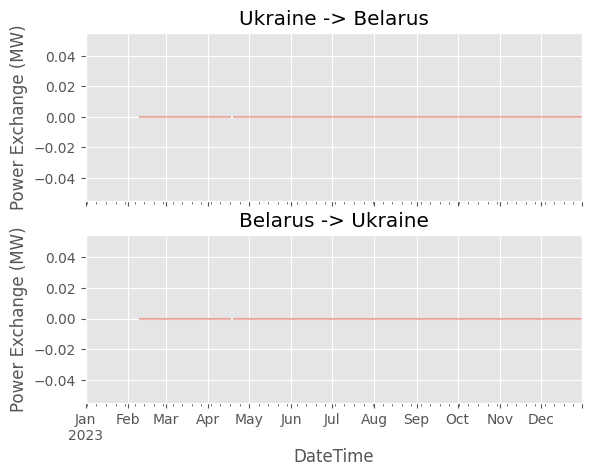

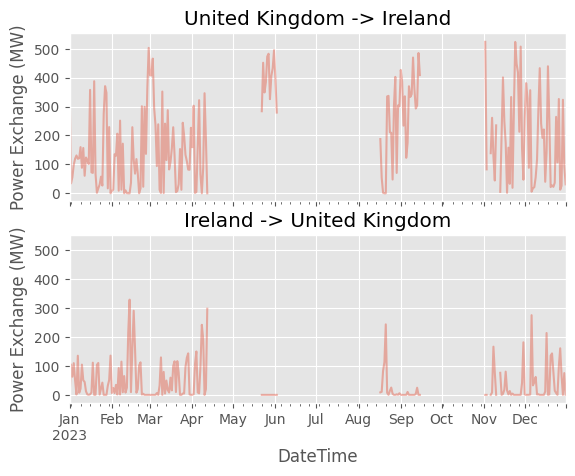

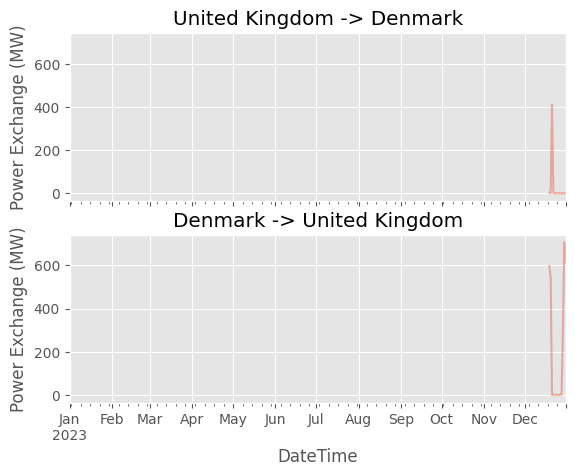

In [16]:
for countries in [["UA", "BY"], ["GB", "IE"], ["GB", "DK"]]:
    fig, ax = viz.plot_check_exchange_data(countries=countries, ede=ede)
    plt.savefig(f"plot/Exchange_{countries[0]}_{countries[1]}.png", bbox_inches="tight")

UK and DK recently put into service an electric connection [Viking Link](https://en.energinet.dk/infrastructure-projects/projektliste/viking-link/). 

- Possibility to fill nan values by interp data over some hours.
- Otherwise, nan will be treated as 0 in later computation.

# 4. Data visualisation

## Generation data

Italy


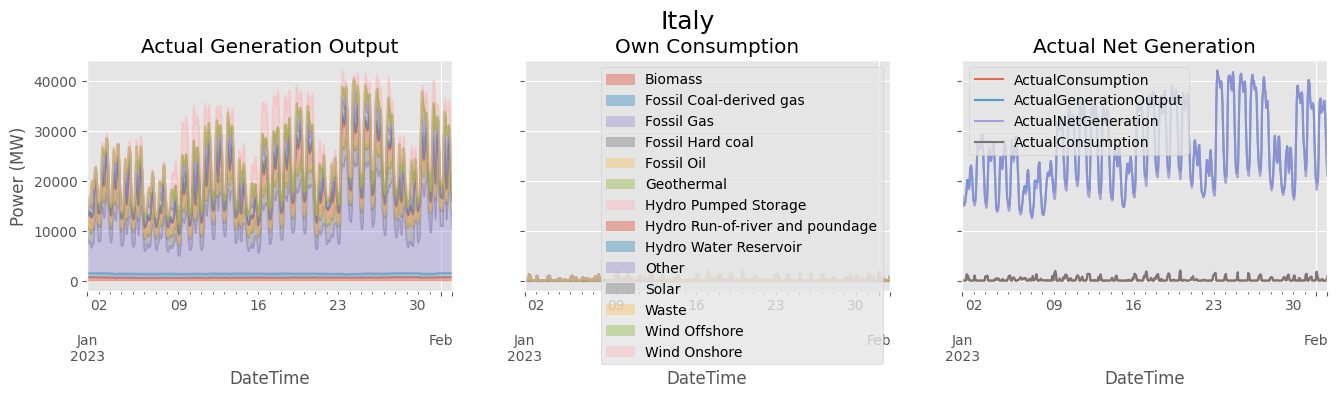

In [17]:
viz.plot_generation_data(
    country_code="IT",
    ds_gen=ede.ds_generation.sel(DateTime=slice("2023-01-01", "2023-02-01")),
)

In [18]:
# As there are sometimes too many categories, we created a new function to add the energy group in the dataset coordinates.
# This enable to groupby energy groups and do some visualatisation with a reduced number of energy categories
from ecodynelec.energy_grouping import add_energy_groups

In [19]:
ds_generation_grouped = add_energy_groups(ede.ds_generation)
ds_generation_grouped = ds_generation_grouped.sum(dim="Subenergies")
ds_generation_grouped

<xarray.Dataset>
Dimensions:                 (Countries: 35, DateTime: 8760, Energies: 7)
Coordinates:
  * Countries               (Countries) <U2 'AT' 'BA' 'BE' ... 'SI' 'SK' 'XK'
  * DateTime                (DateTime) datetime64[ns] 2023-01-01 ... 2023-12-...
  * Energies                (Energies) <U15 'Fossil' 'Nuclear' ... 'Other'
Data variables:
    ActualConsumption       (Energies, DateTime, Countries) float64 0.0 ... 0.0
    ActualGenerationOutput  (Energies, DateTime, Countries) float64 28.2 ... 0.0
    ActualNetGeneration     (Energies, DateTime, Countries) float64 28.2 ... 0.0

Italy


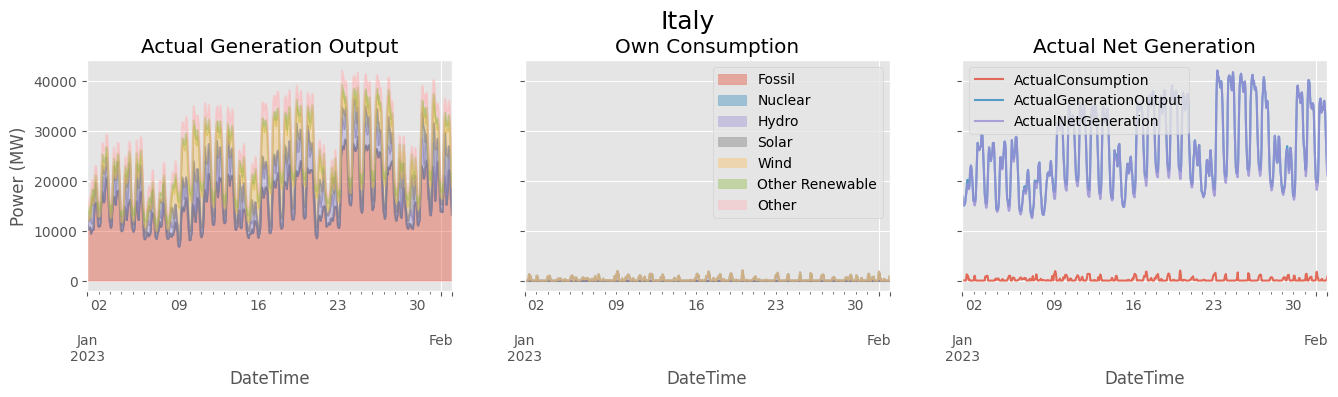

In [20]:
viz.plot_generation_data(
    country_code="IT",
    ds_gen=ede.ds_generation_grouped.sel(DateTime=slice("2023-01-01", "2023-02-01")),
    label_for_unit="Power (MW)",
)

In [21]:
dict_colors = {
    "Wind": "lightblue",
    "Solar": "orange",
    "Other Renewable": "#8EBA42",
    "Hydro": "#348ABD",
    "Nuclear": "purple",
    "Fossil": "#777777",
    "Other": "#FFB5B8",
}
dict_colors.keys()

dict_keys(['Wind', 'Solar', 'Other Renewable', 'Hydro', 'Nuclear', 'Fossil', 'Other'])

Italy


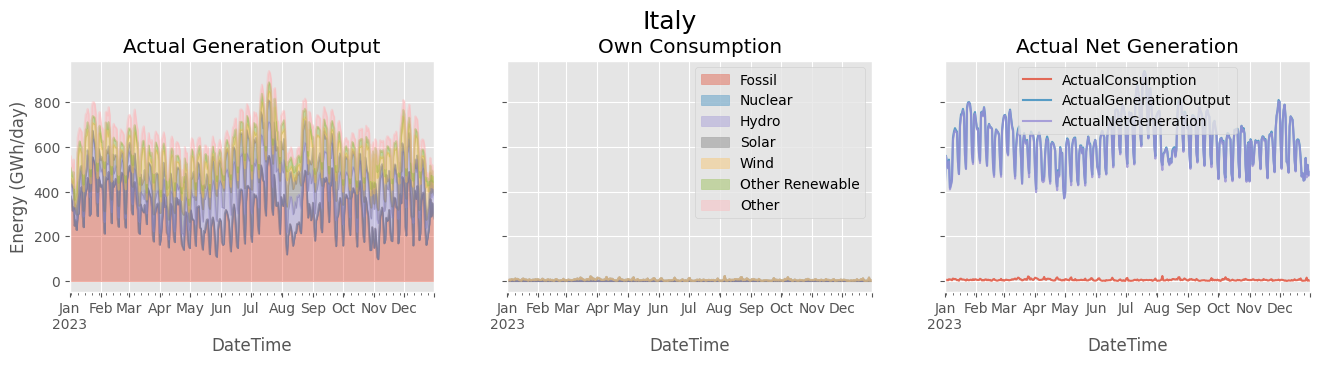

In [22]:
viz.plot_generation_data(
    country_code="IT",
    ds_gen=ede.ds_generation_grouped.resample(DateTime="D").sum() / 1e3,
    label_for_unit="Energy (GWh/day)",
)
plt.savefig("plot/plot_generation_data.png", bbox_inches="tight")

## Exchange data

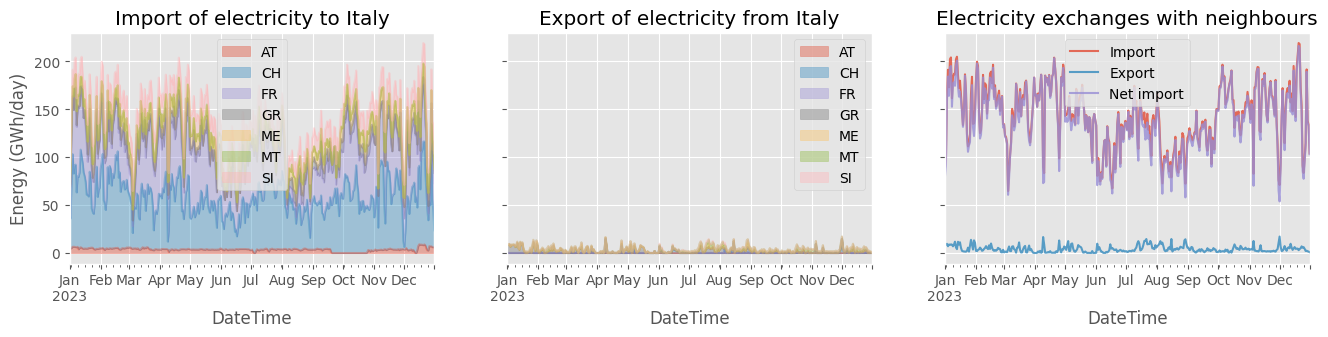

In [23]:
viz.plot_exchange_data(
    country_code="IT",
    ds_exchange=ede.ds_exchange.resample(DateTime="D").sum() / 1e3,
    label_for_unit="Energy (GWh/day)",
)
plt.savefig("plot/plot_exchange_data.png", bbox_inches="tight")

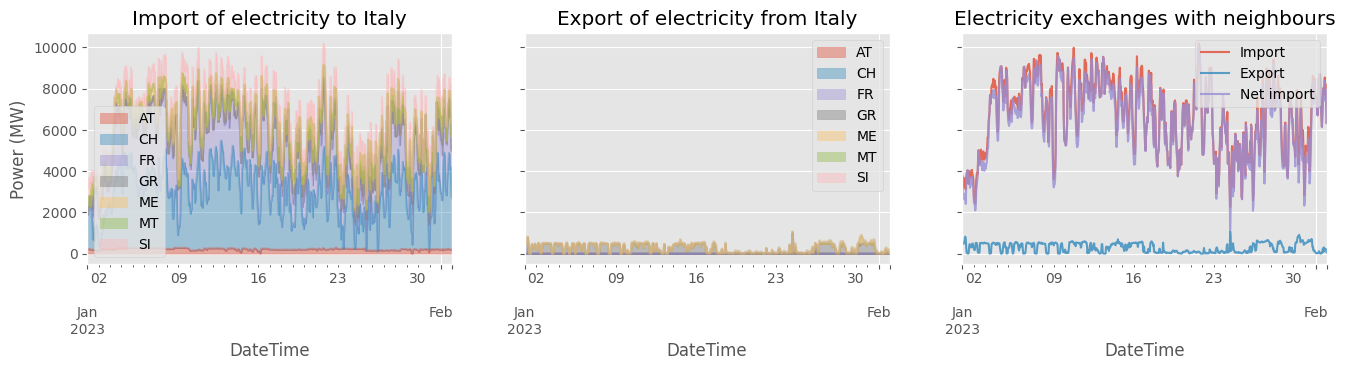

In [24]:
viz.plot_exchange_data(
    country_code="IT",
    ds_exchange=ede.ds_exchange.sel(DateTime=slice("2023-01-01", "2023-02-01")),
)
plt.savefig("plot/plot_exchange_data.png", bbox_inches="tight")

Italy


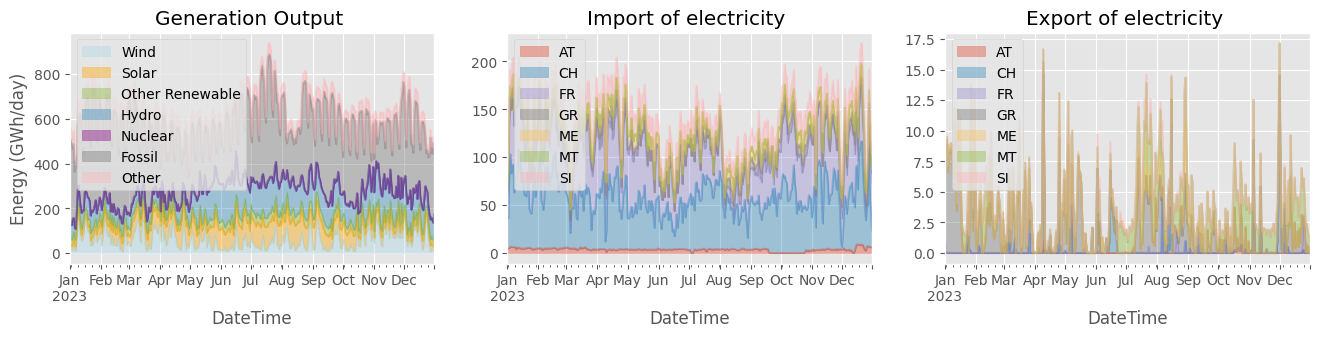

In [25]:
fig, ax = viz.plot_generation_and_trade_data(
    country_code="IT",
    ds_gen=ede.ds_generation_grouped.resample(DateTime="D").sum() / 1e3,
    ds_exchange=ede.ds_exchange.resample(DateTime="D").sum() / 1e3,
    label_for_unit="Energy (GWh/day)",
    sharey=False,
)
ax[0].legend(loc=2)
ax[1].legend(loc=2)
ax[2].legend(loc=2)
plt.suptitle("")
for axi in ax:
    txt = axi.title.get_text()
    txt = txt.split("in ")[0].split("from")[0]
    axi.set_title(txt)
plt.savefig("plot/plot_generation_and_exchange_data.png", bbox_inches="tight")

## Consumption data

Consumption data can be calculated from production and exchanges between countries. However, at that stage, we don't know the "type" (fossil, renewable, nuclear, etc) of energy that are exchanged, we will need to run the tracking algorithm to model exchanges and assess the type of electricity that is exchanged. 

In [26]:
ds_conso = ede.get_consumption_data()
ds_conso

<xarray.Dataset>
Dimensions:                 (Countries: 35, DateTime: 8760)
Coordinates:
  * Countries               (Countries) <U2 'AT' 'BA' 'BE' ... 'SI' 'SK' 'XK'
  * DateTime                (DateTime) datetime64[ns] 2023-01-01 ... 2023-12-...
Data variables:
    ActualConsumption       (DateTime, Countries) float64 1.586e+03 0.0 ... 0.0
    ActualGenerationOutput  (DateTime, Countries) float64 3.598e+03 ... 730.6
    ActualNetGeneration     (DateTime, Countries) float64 2.012e+03 ... 730.6
    Import                  (DateTime, Countries) float64 4.994e+03 ... 631.8
    Export                  (DateTime, Countries) float64 1.93e+03 ... 350.0
    Net_export              (DateTime, Countries) float64 -3.064e+03 ... -281.8
    Consumption             (DateTime, Countries) float64 6.662e+03 ... 1.012...
Attributes:
    unit:     MW

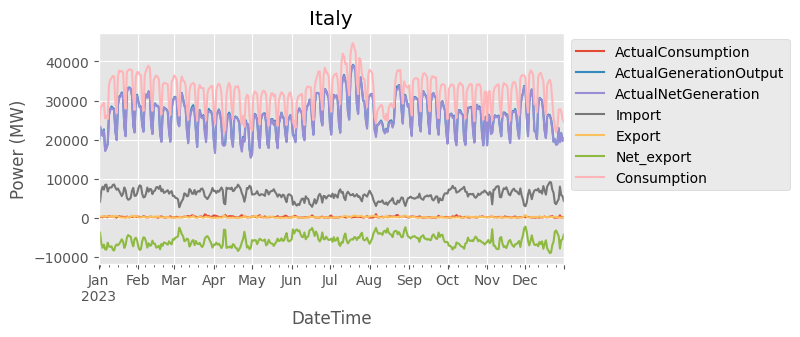

In [27]:
# viz.plot_untracked_consumption(    country_code="IT", ds_conso=ds_conso.sel(DateTime=slice("2023-01-01", "2023-02-01")))
viz.plot_untracked_consumption(
    country_code="IT", ds_conso=ds_conso.resample(DateTime="D").mean()
)
plt.legend(bbox_to_anchor=(1, 1))
plt.suptitle("")
plt.savefig("plot/untracked_consumption_data", bbox_inches="tight")

# 5. Neighbours identification

At the border of ENTSO-E data, we have some exchanges with countries for which we don't have data. We calculate the relative weight of exchanges with those data to ensure the impact is marginal.

In [28]:
list_countries = list(ede.ds_generation.Countries.values)

In [29]:
list_neighbours_ouside_ENTSOE = list(
    set(ede.ds_exchange.Importing_Countries.values)
    - set(ede.ds_generation.Countries.values)
)
list_neighbours_ouside_ENTSOE

['AZ', 'AL', 'TR', 'AM', 'BY', 'MT', 'RU', 'UA']

In [30]:
[
    pycountry.countries.get(alpha_2=country_code).name
    for country_code in list_neighbours_ouside_ENTSOE
]  # ENTSOE countries have exchanges with those countries, but we don't have production data for those countries

['Azerbaijan',
 'Albania',
 'Turkey',
 'Armenia',
 'Belarus',
 'Malta',
 'Russian Federation',
 'Ukraine']

In [31]:
df_ratio_neighbours = (
    ede.ds_exchange.sel(
        Exporting_Countries=list_neighbours_ouside_ENTSOE
    ).FlowValue.sum(dim=["Importing_Countries", "DateTime"])
    / ede.ds_generation.ActualGenerationOutput.sum(
        dim=["Countries", "Energies", "DateTime"]
    )
).to_dataframe(name="Import")
df_ratio_neighbours["Export"] = (
    ede.ds_exchange.sel(
        Importing_Countries=list_neighbours_ouside_ENTSOE
    ).FlowValue.sum(dim=["Exporting_Countries", "DateTime"])
    / ede.ds_generation.ActualGenerationOutput.sum(
        dim=["Countries", "Energies", "DateTime"]
    )
).to_dataframe(name="Export")

df_ratio_neighbours["Net_import"] = (
    df_ratio_neighbours.Import - df_ratio_neighbours.Export
)
df_ratio_neighbours.index = [
    pycountry.countries.get(alpha_2=country_code).name.replace(" ", "\n")
    for country_code in df_ratio_neighbours.index
]
df_ratio_neighbours

Import    Export  Net_import
Azerbaijan           0.001114  0.000032    0.001082
Albania              0.000949  0.000614    0.000335
Turkey               0.000564  0.002213   -0.001649
Armenia              0.000052  0.000029    0.000024
Belarus              0.000475  0.000042    0.000433
Malta                0.000009  0.000236   -0.000228
Russian\nFederation  0.000695  0.000651    0.000044
Ukraine              0.001500  0.001698   -0.000198

In [32]:
df_ratio_neighbours.sum()

Import        0.005358
Export        0.005515
Net_import   -0.000157
dtype: float64

Export and import from neighbours of ENTSO-E countries represent half a percent of the ENTSO-E production. It can locally have a visible impact, if electricity mix with neighbours are really difference. But export and import with those countries are balanced, the net difference if 1 per thousand only.

Text(0.5, 1.0, 'Relative weight of exchanges with ENTSO-E neighbours')

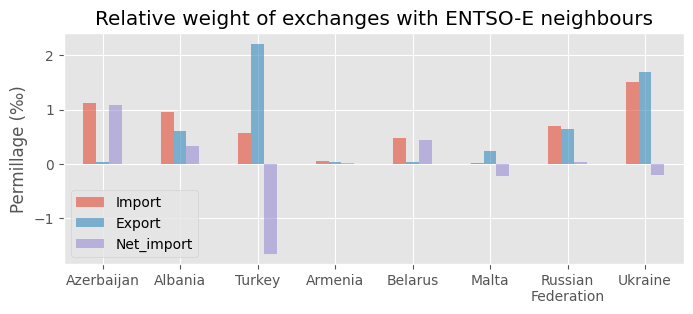

In [33]:
fig, ax = plt.subplots(figsize=(8, 3))
(1000 * df_ratio_neighbours).plot(ax=ax, kind="bar", stacked=False, alpha=0.6, rot=0)
ax.set_ylabel("Permillage (‰)")

plt.savefig("plot/Neighbours_outside_ENTSOE.png", bbox_inches="tight")
ax.set_title("Relative weight of exchanges with ENTSO-E neighbours")

## Find neighbours of a list of countries

In [34]:
from ecodynelec.neighbours import (
    find_neighbours_for_country,
    find_neighbours_for_countries,
)

In [35]:
find_neighbours_for_country(
    country_code="IT", ds_exchange=ede.ds_exchange.resample(DateTime="M").max()
)

['AT', 'GR', 'ME', 'FR', 'MT', 'CH', 'SI']

In [36]:
list_external_neighbours = find_neighbours_for_countries(
    list_countries=["AT", "CH", "CZ", "DE", "FR", "IT"],
    ds_exchange=ede.ds_exchange.resample(DateTime="M").max(),
)
list_external_neighbours

['NL',
 'SE',
 'GR',
 'GB',
 'ME',
 'DK',
 'SK',
 'NO',
 'LU',
 'PL',
 'BE',
 'ES',
 'MT',
 'SI',
 'HU']

In [37]:
list_external_neighbours = find_neighbours_for_countries(
    list_countries=ede.ds_generation.Countries.values,
    ds_exchange=ede.ds_exchange.resample(DateTime="M").max(),
)
list_external_neighbours

['AZ', 'AL', 'TR', 'AM', 'BY', 'MT', 'RU', 'UA']

# 6. Track electricity mix

## Influence of net production


In [38]:
dict_ds_mix = {}

for i, net_generation in enumerate([True, False]):
    print(f"Net production is {net_generation}")
    ds_mix = ede.track_mix(freq="MS", net_generation=net_generation, force=False)
    dict_ds_mix[
        net_generation
    ] = ds_mix_grouped = ecodynelec.energy_grouping.add_energy_groups(ds_mix)

Net production is True
Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...
Net production is False
Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...


C:\Users\romai\AppData\Local\Temp\ipykernel_25620\482452848.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("Consumption_Countries")


Fossil             5.307573
Nuclear            0.985058
Hydro              2.241394
Solar              1.184477
Wind               1.218743
Other Renewable    0.546906
Other              0.717354
dtype: float64

C:\Users\romai\AppData\Local\Temp\ipykernel_25620\482452848.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("Consumption_Countries")


Fossil             5.267335
Nuclear            0.972072
Hydro              2.325648
Solar              1.174985
Wind               1.206970
Other Renewable    0.542331
Other              0.712341
dtype: float64

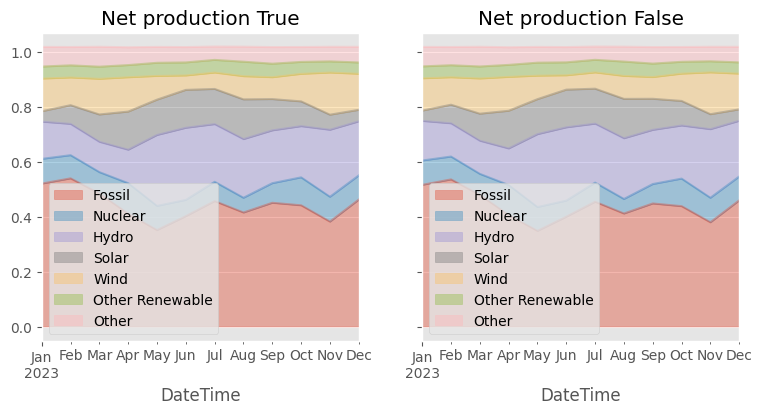

In [39]:
country = "IT"
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)

for i, (net_generation, ds_mix_grouped) in enumerate(dict_ds_mix.items()):
    dfp = (
        ds_mix_grouped.sum(dim="Subenergies")
        .sel(Consumption_Countries=country)
        .drop("Consumption_Countries")
        .sum(dim="Production_Countries")
        .to_dataset("Energies")
        .to_dataframe()
    )

    dfp.plot(kind="area", stacked=True, alpha=0.4, ax=ax[i])
    ax[i].set_title(f"Net production {net_generation}")

    display(dfp.sum())

## Influence of net exchange

In [40]:
dict_ds_mix = {}

for i, net_exchange in enumerate([True, False]):
    print(f"Net generation is {net_exchange}")
    ds_mix = ede.track_mix(freq="MS", net_exchange=net_exchange, force=False)
    dict_ds_mix[
        net_exchange
    ] = ds_mix_grouped = ecodynelec.energy_grouping.add_energy_groups(ds_mix)

Net generation is True
Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...
Net generation is False
Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...


C:\Users\romai\AppData\Local\Temp\ipykernel_25620\319715073.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("Consumption_Countries")


Fossil             5.291814
Nuclear            1.010108
Hydro              2.272898
Solar              1.178928
Wind               1.199108
Other Renewable    0.542526
Other              0.717701
dtype: float64

C:\Users\romai\AppData\Local\Temp\ipykernel_25620\319715073.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("Consumption_Countries")


Fossil             5.307573
Nuclear            0.985058
Hydro              2.241394
Solar              1.184477
Wind               1.218743
Other Renewable    0.546906
Other              0.717354
dtype: float64

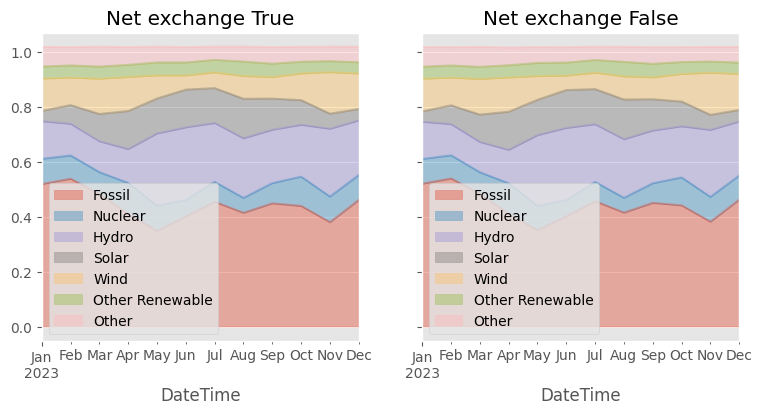

In [41]:
country = "IT"
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)

for i, (net_exchange, ds_mix_grouped) in enumerate(dict_ds_mix.items()):
    dfp = (
        ds_mix_grouped.sum(dim="Subenergies")
        .sel(Consumption_Countries=country)
        .drop("Consumption_Countries")
        .sum(dim="Production_Countries")
        .to_dataset("Energies")
        .to_dataframe()
    )

    dfp.plot(kind="area", stacked=True, alpha=0.4, ax=ax[i])
    ax[i].set_title(f"Net exchange {net_exchange}")

    display(dfp.sum())

## Calculate for all time step

In [42]:
for freq in ["Y", "M", "W", "D"]:
    print(freq)
    ds_mix = ede.track_mix(
        freq=freq, net_exchange=False, net_generation=True, force=False
    )

Y
Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...
M
Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...
W
Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...
D
Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...


In [43]:
ds_mix = ede.track_mix(freq="H", net_exchange=False, net_generation=True, force=False)

Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...


c:\Users\romai\anaconda3\envs\python311\Lib\site-packages\xarray\core\indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\romai\anaconda3\envs\python311\Lib\site-packages\xarray\core\indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\r

# 7. Consumption mix analysis

## Share of consumption unidentified

In [44]:
ds_mix = ede.track_mix(
    freq="A",
    net_exchange=False,
    net_generation=True,
)

Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...


In [45]:
df = (
    ds_mix.sel(Energies="Grid", Production_Countries="External_neighbours")
    .drop(["Production_Countries", "Energies"])
    .mean(dim="DateTime")
    .to_dataframe("External_grid")
)
df = df.sort_values(by="External_grid", ascending=False)

C:\Users\romai\AppData\Local\Temp\ipykernel_25620\1539492177.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(["Production_Countries", "Energies"])


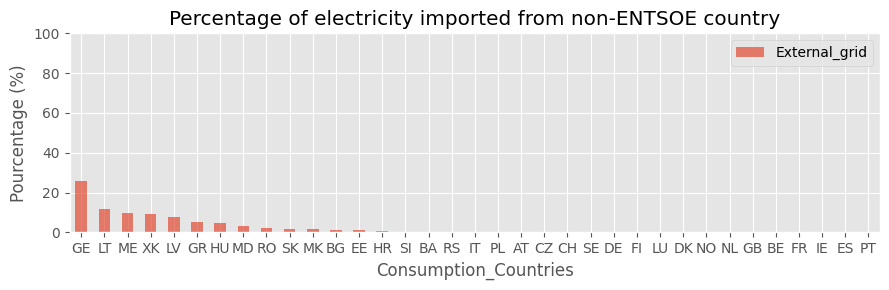

In [46]:
fig, ax = plt.subplots(figsize=(9, 3))
(100 * df).plot(ax=ax, kind="bar", alpha=0.7, rot=0)
ax.set_title("Percentage of electricity imported from non-ENTSOE country")
ax.set_ylabel("Pourcentage (%)")
ax.set_ylim([0, 100])
plt.tight_layout()
plt.savefig("plot/Consumption_from_outside_ENTSOE.png", bbox_inches="tight")

In [47]:
for country_code in df.sort_values("External_grid", ascending=False).index[0:10]:
    try:
        country = pycountry.countries.get(alpha_2=country_code)
        print(f"{country_code}:{country.name}")
    except:
        print(country_code)

GE:Georgia
LT:Lithuania
ME:Montenegro
XK
LV:Latvia
GR:Greece
HU:Hungary
MD:Moldova, Republic of
RO:Romania
SK:Slovakia


In [48]:
df = (
    ds_mix.sel(Energies="Other")
    .drop("Energies")
    .mean(dim="DateTime")
    .sum(dim="Production_Countries")
    .to_dataframe("Consumption")
)
df["Production"] = (
    ds_mix.sel(Energies="Other")
    .drop("Energies")
    .mean(dim="DateTime")
    .sum(dim="Consumption_Countries")
    .to_dataframe("Production_Countries")
).Production_Countries
df = df.sort_values(by="Production", ascending=False)

C:\Users\romai\AppData\Local\Temp\ipykernel_25620\2545485404.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("Energies")
C:\Users\romai\AppData\Local\Temp\ipykernel_25620\2545485404.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("Energies")


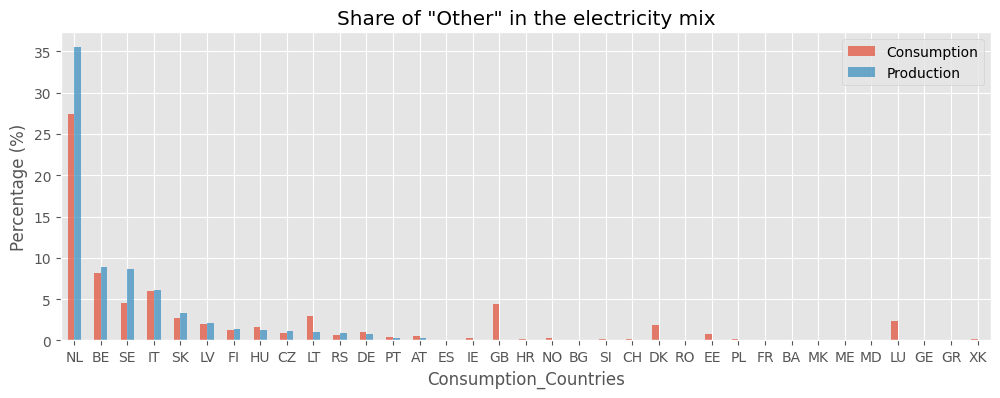

In [49]:
fig, ax = plt.subplots(figsize=(12, 4))
(100 * df).plot(ax=ax, kind="bar", alpha=0.7, rot=0)
ax.set_ylabel("Percentage (%)")
ax.set_title('Share of "Other" in the electricity mix')
plt.savefig("plot/consumption_of_other.png", bbox_inches="tight")

Netherlands


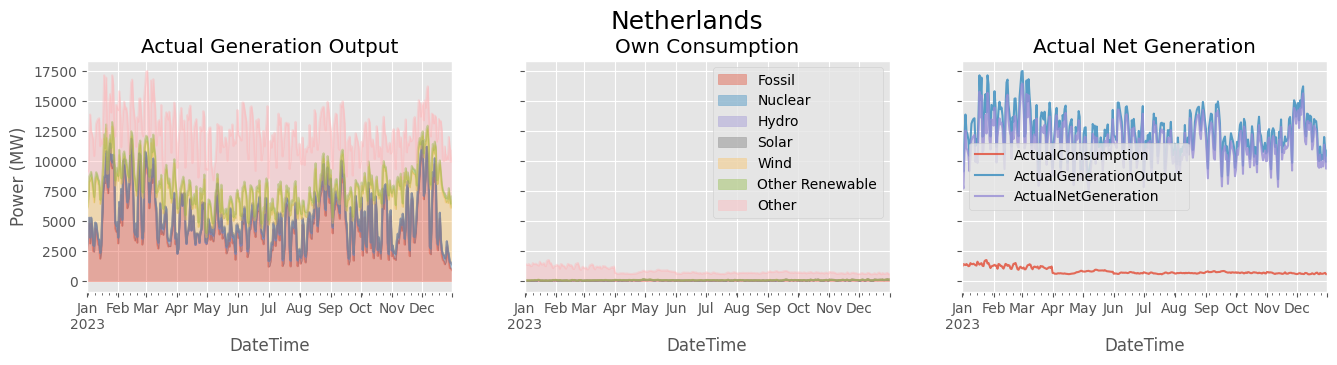

In [50]:
ecodynelec.visualisation.plot_generation_data(
    country_code="NL", ds_gen=ede.ds_generation_grouped.resample(DateTime="D").mean()
)

<Axes: ylabel='ActualGenerationOutput'>

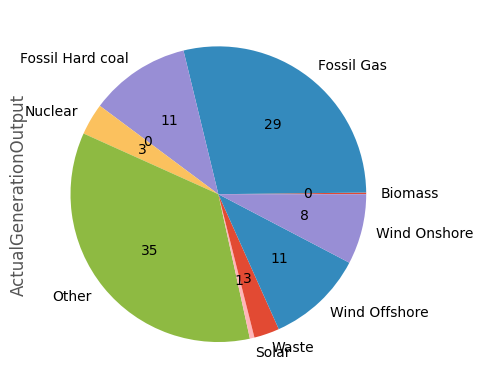

In [51]:
ede.ds_generation.sel(Countries="NL").mean(
    dim="DateTime"
).to_dataframe().ActualGenerationOutput.dropna().plot(
    kind="pie", stacked=True, autopct="%.0f"
)

## By energy type and country

In [52]:
freq = "D"
country_code = "IT"
country_name = pycountry.countries.get(alpha_2=country_code).name

In [53]:
ds_mix = ede.track_mix(freq="D", grid_loss=None)

Calculating energy groups...


In [54]:
ede.get_dict_country_name()

{'AT': 'Austria',
 'BA': 'Bosnia and Herzegovina',
 'BE': 'Belgium',
 'BG': 'Bulgaria',
 'CH': 'Switzerland',
 'CZ': 'Czechia',
 'DE': 'Germany',
 'DK': 'Denmark',
 'EE': 'Estonia',
 'ES': 'Spain',
 'FI': 'Finland',
 'FR': 'France',
 'GB': 'United Kingdom',
 'GE': 'Georgia',
 'GR': 'Greece',
 'HR': 'Croatia',
 'HU': 'Hungary',
 'IE': 'Ireland',
 'IT': 'Italy',
 'LT': 'Lithuania',
 'LU': 'Luxembourg',
 'LV': 'Latvia',
 'MD': 'Moldova, Republic of',
 'ME': 'Montenegro',
 'MK': 'North Macedonia',
 'NL': 'Netherlands',
 'NO': 'Norway',
 'PL': 'Poland',
 'PT': 'Portugal',
 'RO': 'Romania',
 'RS': 'Serbia',
 'SE': 'Sweden',
 'SI': 'Slovenia',
 'SK': 'Slovakia',
 'XK': 'Kosovo'}

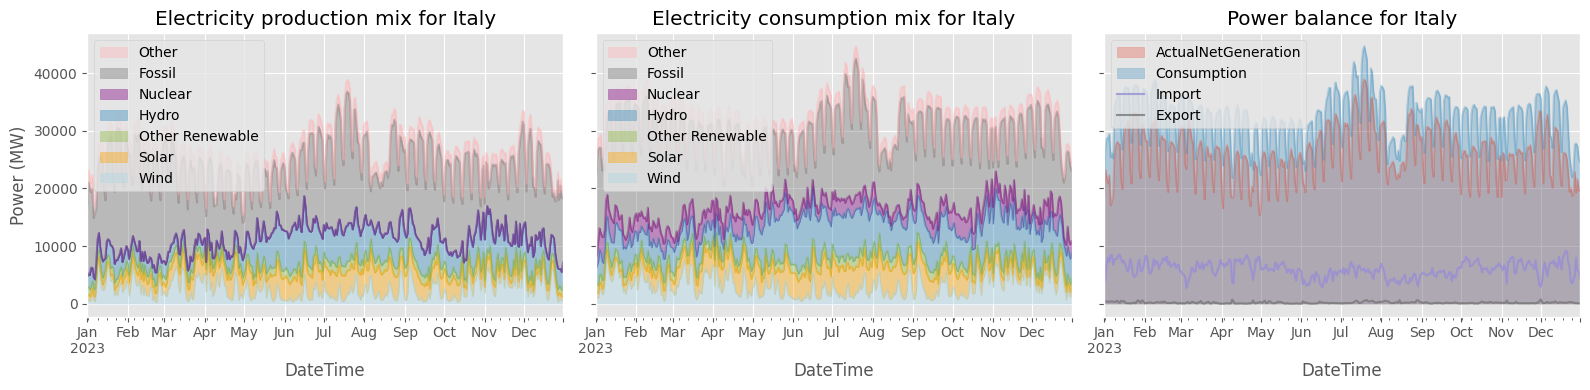

In [55]:
ecodynelec.visualisation.plot_prod_conso_and_trade(
    country_code="IT",
    ds_generation=ede.ds_generation_grouped.resample(DateTime="D").mean(),
    ds_consumption_tracked=ede.ds_consumption_tracked_grouped.resample(
        DateTime="D"
    ).mean(),
    ds_consumption_untracked=ede.ds_consumption_untracked.resample(DateTime="D").mean(),
    dict_country_name=ede.dict_country_name,
)
plt.savefig("plot/plot_prod_conso_and_trade.png", bbox_inches="tight")

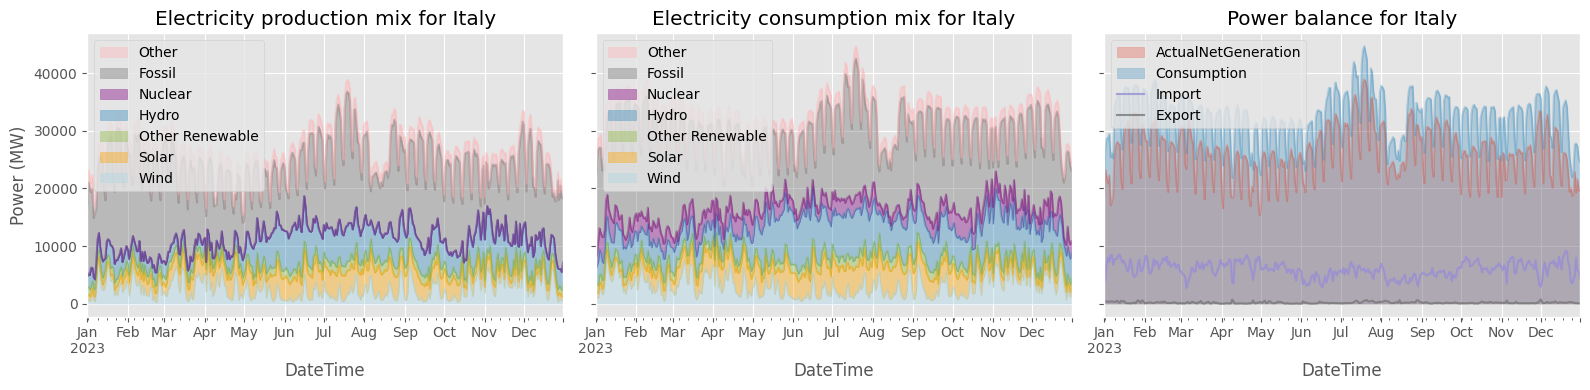

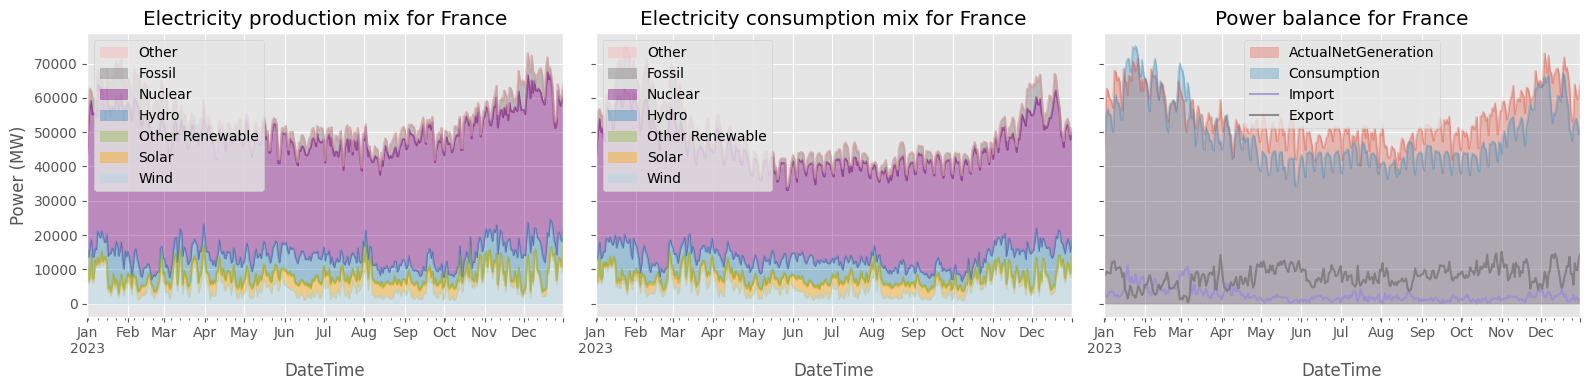

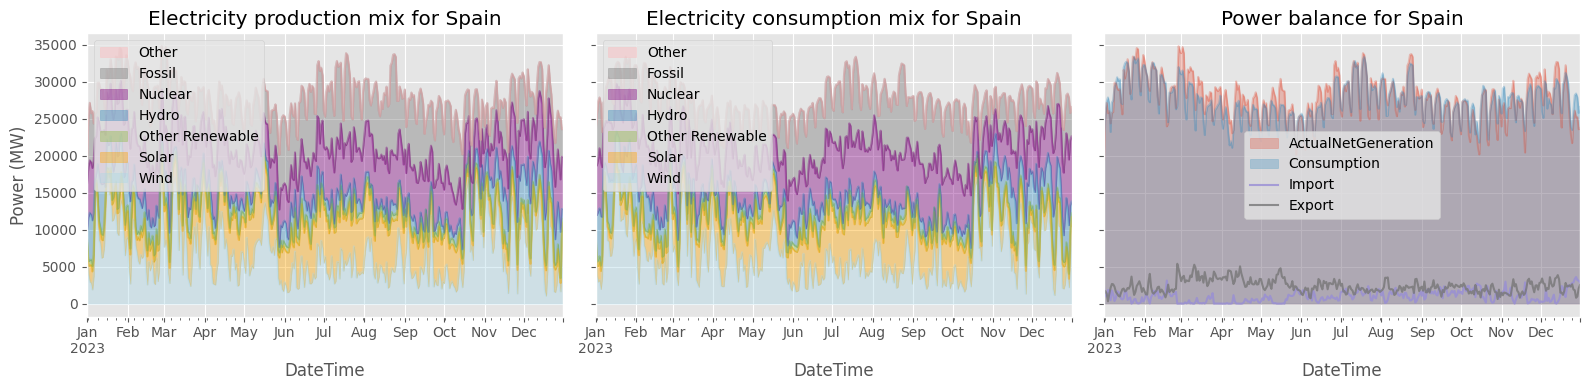

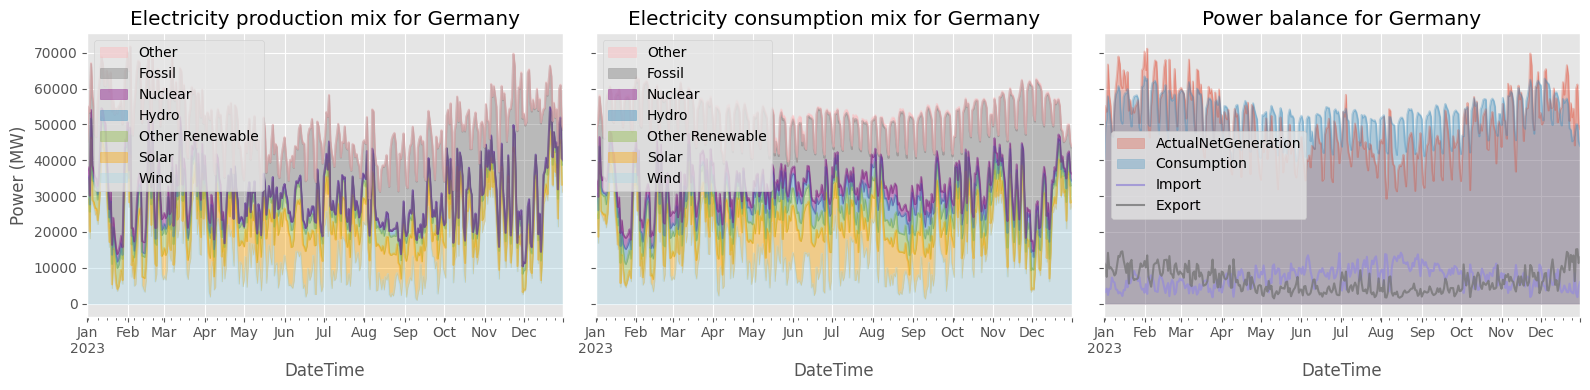

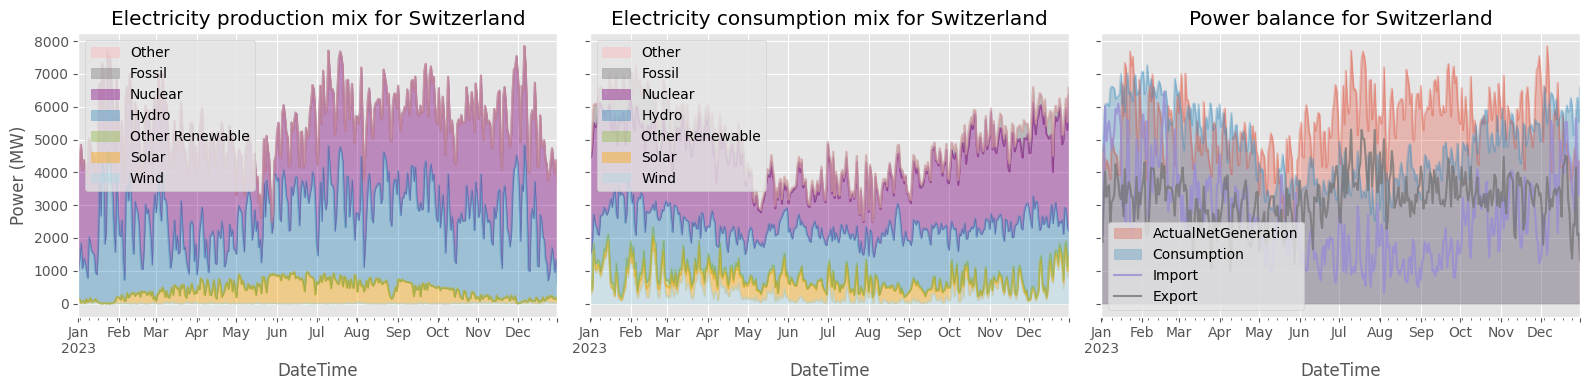

In [56]:
for country_code in ["IT", "FR", "ES", "DE", "CH"]:
    ecodynelec.visualisation.plot_prod_conso_and_trade(
        country_code=country_code,
        ds_generation=ede.ds_generation_grouped.resample(DateTime="D").mean(),
        ds_consumption_tracked=ede.ds_consumption_tracked_grouped.resample(
            DateTime="D"
        ).mean(),
        ds_consumption_untracked=ede.ds_consumption_untracked.resample(
            DateTime="D"
        ).mean(),
        dict_country_name=ede.dict_country_name,
    )

# 8. Footprint of electricity mix

In [57]:
ede.set_download_config()
ede.get_generation_data()
ede.get_exchange_data()
ede.get_consumption_data()
ds_mix = ede.track_mix(
    freq="H", net_exchange=False, net_generation=True, grid_loss="TRANSL"
)

Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...


c:\Users\romai\anaconda3\envs\python311\Lib\site-packages\xarray\core\indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\romai\anaconda3\envs\python311\Lib\site-packages\xarray\core\indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\r

In [58]:
ds_EF = ede.get_emission_factor_data()
ds_EF

<xarray.DataArray (Energies: 21, Emission_phase: 2)>
[42 values with dtype=float64]
Coordinates:
  * Emission_phase  (Emission_phase) <U10 'Upstream' 'Combustion'
  * Energies        (Energies) <U31 'Biomass' ... 'Wind Onshore'

Text(0.5, 1.0, 'Carbon intensity of electricity sources')

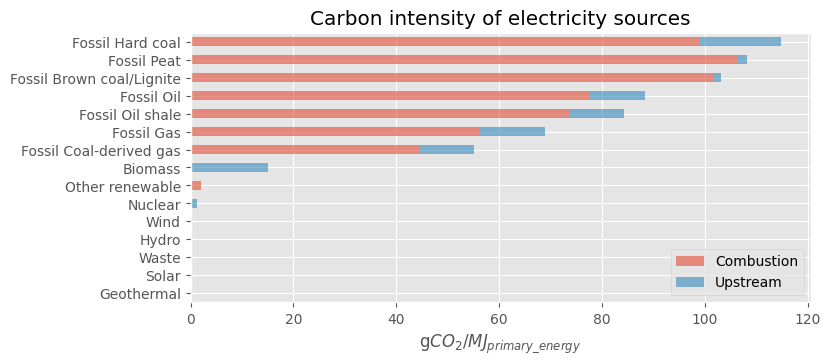

In [59]:
fig, ax = plt.subplots(figsize=(8, 3.5))
dfp = ds_EF.to_dataset("Emission_phase").to_dataframe()
dfp = dfp.drop(
    ["Grid", "Other"], axis=0
)  # Grid is used for electricity from grid for external neighbours
# Remove the three subcategories of hydro to keep only one named Hydro
dfp = dfp.loc[[idx for idx in dfp.index if not "Hydro" in idx]]
dfp.loc["Hydro"] = 0
# Idem for wind
dfp = dfp.loc[[idx for idx in dfp.index if not "Wind" in idx]]
dfp.loc["Wind"] = 0
dfp["Total"] = dfp.sum(axis=1)
dfp = dfp.sort_values("Total")
dfp = dfp[["Combustion", "Upstream"]]
dfp = dfp.drop("Marine", axis=0)
(dfp / 3.6).plot(kind="barh", alpha=0.6, ax=ax, stacked=True)
ax.set_xlabel("g$CO_2$/$MJ_{primary\_energy}$")

plt.legend(loc=4)
ax.set_ylabel("")
plt.savefig("plot/carbon_intensity_by_source.png", bbox_inches="tight")
ax.set_title("Carbon intensity of electricity sources")

In [60]:
ede.get_carbon_footprint()

Missing countries (filled by quantile 0.5):
['GB', 'External_neighbours']


In [61]:
# ede.compute()

In [62]:
ede.get_EU_value()

Missing countries (filled by quantile 0.5):
['GB', 'External_neighbours']


221.28144213228768

In [63]:
dict_country_name = ede.get_dict_country_name()
dict_country_name["MD"] = "Moldova"

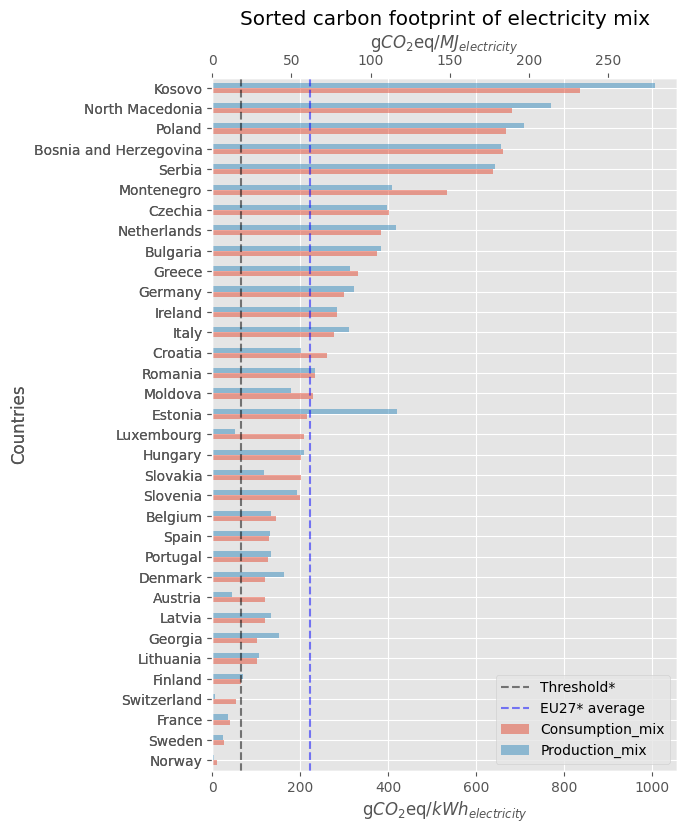

In [64]:
df = pd.DataFrame()
df["Consumption_mix"] = (
    ede.ds_CI_grouped.sel(Method="Consumption")
    .drop_vars("Method")
    .sum(dim=["Emission_phase", "Energies", "Production_Countries"])
    .mean(dim="DateTime")
    .to_dataframe("CF")
)

df["Production_mix"] = (
    ede.ds_CI_grouped.sel(Method="Production")
    .drop_vars("Method")
    .sum(dim=["Emission_phase", "Energies"])
    .mean("Consumption_Countries")  # value independant over that dimension
    .mean(dim="DateTime")
).to_dataframe("CF")

df.index.name = "Countries"
df = df.drop("GB")

fig, ax = plt.subplots(figsize=(6, 9))

ax2 = ax.twiny()

dfp = df.rename(dict_country_name).sort_values(by="Consumption_mix")

dfp.plot(kind="barh", ax=ax, alpha=0.5)

(dfp / 3.6).plot(kind="barh", ax=ax2, alpha=0, legend=False)


ax.set_xlabel("g$CO_2$eq/$kWh_{electricity}$")

ax2.set_xlabel("g$CO_2$eq/$MJ_{electricity}$")

ax2.grid(False)

ax.set_title("Sorted carbon footprint of electricity mix")

ax.axvline(x=18.3 * 3.6, ls="--", color="k", alpha=0.5, label="Threshold*")
ax.axvline(
    x=ede.EU_value,
    ls="--",
    color="blue",
    alpha=0.5,
    label="EU27* average",
)
ax.legend()

plt.savefig("plot/carbon_footprint_sorted.png", bbox_inches="tight")

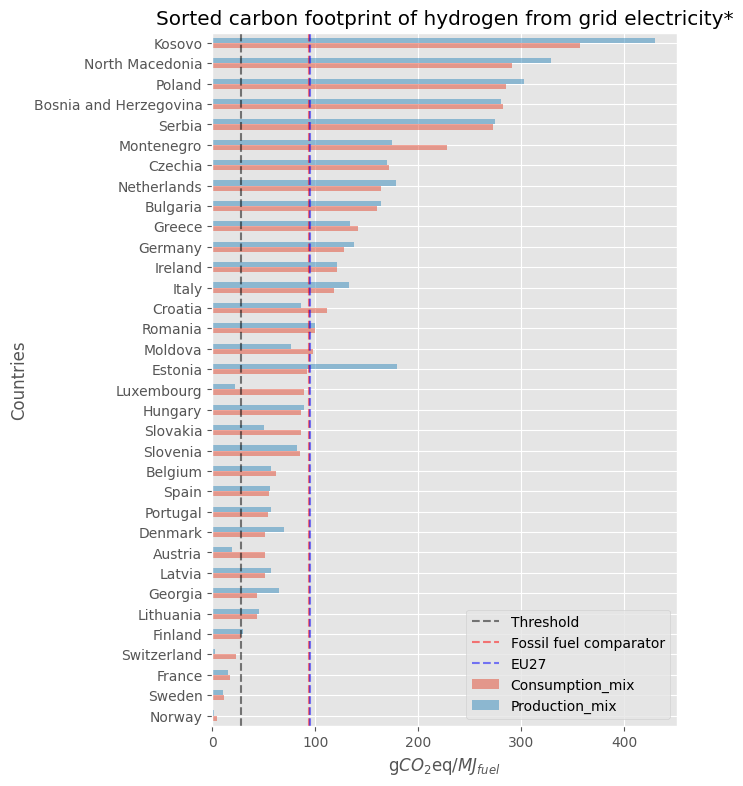

In [65]:
efficiency = 0.65

df = pd.DataFrame()
df["Consumption_mix"] = (
    ede.ds_CI_grouped.sel(Method="Consumption")
    .drop_vars("Method")
    .sum(dim=["Emission_phase", "Energies", "Production_Countries"])
    .mean(dim="DateTime")
    .to_dataframe("CF")
)
df["Production_mix"] = (
    ede.ds_CI_grouped.sel(Method="Production")
    .drop_vars("Method")
    .sum(dim=["Emission_phase", "Energies"])
    .mean("Consumption_Countries")  # value independant over that dimension
    .mean(dim="DateTime")
).to_dataframe("CF")

df.index.name = "Countries"
df = df.drop("GB")
df = df / efficiency / 3.6  # gCO2eq/MJ of hydrogene

fig, ax = plt.subplots(figsize=(6, 9))
dfp = df.rename(dict_country_name).sort_values(by="Consumption_mix")
dfp.plot(kind="barh", ax=ax, alpha=0.5)
ax.set_xlabel("g$CO_2$eq/$MJ_{fuel}$")
ax.set_title("Sorted carbon footprint of hydrogen from grid electricity*")

ax.axvline(x=94 * 0.3, ls="--", color="k", alpha=0.5, label="Threshold")
ax.axvline(x=94, ls="--", color="r", alpha=0.5, label="Fossil fuel comparator")
ax.axvline(
    x=ede.EU_value / efficiency / 3.6,
    ls="--",
    color="blue",
    alpha=0.5,
    label="EU27",
)
ax.legend()

plt.savefig("plot/carbon_footprint_of_H2.png", bbox_inches="tight")

In [66]:
print(dfp.shape)
display((dfp < 94 * 0.3).sum())
display(((dfp >= 94 * 0.3) & (dfp < 94)).sum())
display((dfp >= 94).sum())

(34, 2)


Consumption_mix    5
Production_mix     6
dtype: int64

Consumption_mix    13
Production_mix     13
dtype: int64

Consumption_mix    16
Production_mix     15
dtype: int64

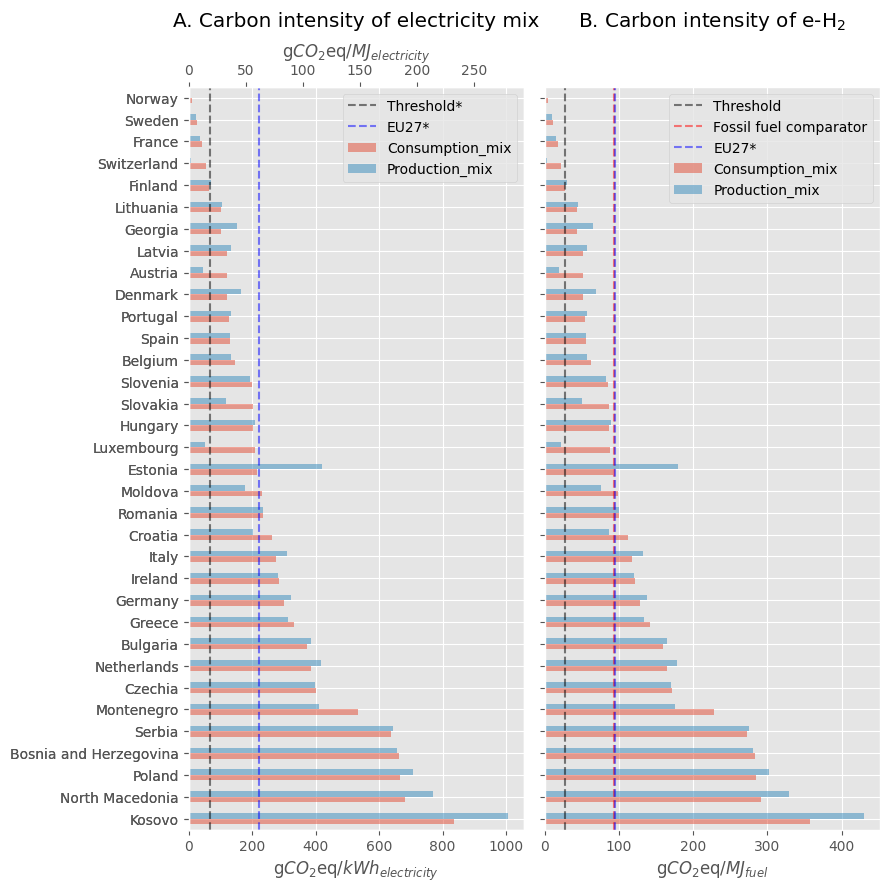

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(9, 9), sharey=True)
ax0b = ax[0].twiny()

# Elec
df = pd.DataFrame()
df["Consumption_mix"] = (
    ede.ds_CI_grouped.sel(Method="Consumption")
    .drop_vars("Method")
    .sum(dim=["Emission_phase", "Energies", "Production_Countries"])
    .mean(dim="DateTime")
    .to_dataframe("CF")
)
df["Production_mix"] = (
    ede.ds_CI_grouped.sel(Method="Production")
    .drop_vars("Method")
    .sum(dim=["Emission_phase", "Energies"])
    .mean("Consumption_Countries")  # value independant over that dimension
    .mean(dim="DateTime")
).to_dataframe("CF")

df.index.name = "Countries"
df = df.drop("GB")
dfp = df.rename(dict_country_name).sort_values(by="Consumption_mix", ascending=False)

dfp.plot(kind="barh", ax=ax[0], alpha=0.5)
(dfp / 3.6).plot(kind="barh", ax=ax0b, alpha=0, legend=False)
ax[0].set_xlabel("g$CO_2$eq/$kWh_{electricity}$")
ax[0].set_ylabel("")
ax0b.set_ylabel("")
ax0b.set_xlabel("g$CO_2$eq/$MJ_{electricity}$")
ax0b.grid(False)
ax[0].set_title("A. Carbon intensity of electricity mix", y=1.07)
ax[0].axvline(x=18.3 * 3.6, ls="--", color="k", alpha=0.5, label="Threshold*")
ax[0].axvline(
    x=ede.EU_value,
    ls="--",
    color="blue",
    alpha=0.5,
    label="EU27*",
)
ax[0].legend()

# H2
efficiency = 0.65
df = df / efficiency / 3.6  # gCO2eq/MJ of hydrogene

dfp = df.rename(dict_country_name).sort_values(by="Consumption_mix", ascending=False)
dfp.plot(kind="barh", ax=ax[1], alpha=0.5)
ax[1].set_xlabel("g$CO_2$eq/$MJ_{fuel}$")
ax[1].set_title("B. Carbon intensity of e-H$_2$", y=1.07)

ax[1].axvline(x=94 * 0.3, ls="--", color="k", alpha=0.5, label="Threshold")
ax[1].axvline(x=94, ls="--", color="r", alpha=0.5, label="Fossil fuel comparator")
ax[1].axvline(
    x=ede.EU_value / efficiency / 3.6,
    ls="--",
    color="blue",
    alpha=0.5,
    label="EU27*",
)
ax[1].legend()
plt.tight_layout()
plt.savefig("plot/carbon_footprint_elec_H2.png", bbox_inches="tight")

In [68]:
def step_resample(df, timestep):
    df2 = df.resample(timestep).mean()
    df2.loc[df.index[0]] = np.nan
    df2 = df2.sort_index()
    df2 = df2.resample("D").first().bfill()
    return df2

Text(0.5, 1.0, 'Comparison of hydrogen carbon intensities related to electricity use in Austria')

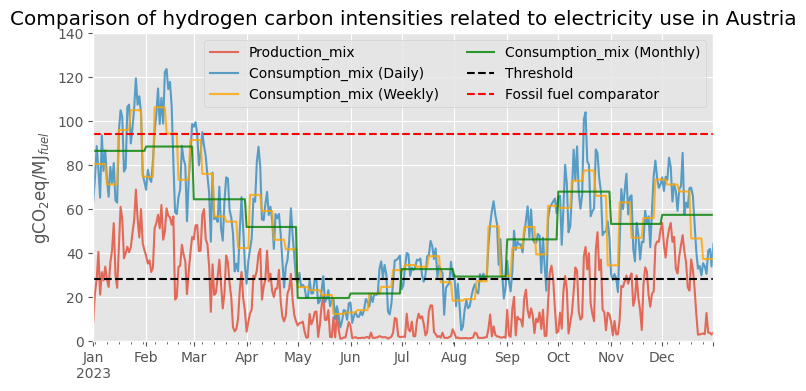

In [69]:
country_code = "AT"
country_name = pycountry.countries.get(alpha_2=country_code).name

dfp = pd.DataFrame()
dfp["Production_mix"] = (
    ede.ds_CI_grouped.sel(Method="Production", Production_Countries=country_code)
    .drop_vars("Method")
    .sum(dim=["Emission_phase", "Energies"])
    .mean("Consumption_Countries")  # value independant over that dimension
    .to_dataframe("CF")
    .CF
)

dfp["Consumption_mix (Daily)"] = (
    ede.ds_CI_grouped.sel(Method="Consumption", Consumption_Countries=country_code)
    .drop_vars("Method")
    .sum(dim=["Emission_phase", "Energies", "Production_Countries"])
    .to_dataframe("CF")
    .CF
)
dfp = dfp.resample("D").mean() / efficiency / 3.6

fig, ax = plt.subplots(figsize=(8, 4))
dfp.plot(ax=ax, kind="line", alpha=0.8)
dfp2 = step_resample(df=dfp["Consumption_mix (Daily)"], timestep="W")
dfp2.plot(
    ax=ax, kind="line", alpha=0.8, color="orange", label="Consumption_mix (Weekly)"
)
dfp2 = step_resample(df=dfp["Consumption_mix (Daily)"], timestep="M")
dfp2.plot(
    ax=ax, kind="line", alpha=0.8, color="green", label="Consumption_mix (Monthly)"
)
ax.axhline(y=94 * 0.3, ls="--", c="k", label="Threshold")
ax.axhline(y=94, ls="--", c="r", label="Fossil fuel comparator")
ax.set_ylabel("gCO$_2$eq/MJ$_{fuel}$")
ax.legend(
    ncol=2,
)
plt.ylim([0, 140])
plt.xlabel("")

plt.savefig(f"plot/H2_time_series_{country_code}.png", bbox_inches="tight")
ax.set_title(
    f"Comparison of hydrogen carbon intensities related to electricity use in {country_name}"
)

In [70]:
ds_mix = ede.track_mix(
    freq="H", net_exchange=False, net_generation=True, grid_loss=None
)
ede.get_carbon_footprint()
ede.compute()

Calculating energy groups...


c:\Users\romai\anaconda3\envs\python311\Lib\site-packages\xarray\core\indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\romai\anaconda3\envs\python311\Lib\site-packages\xarray\core\indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\r

Missing countries (filled by quantile 0.5):
['GB', 'External_neighbours']


In [71]:
for country_code in []:  # ede.ds_CI.Consumption_Countries.values:
    print(country_code)

    viz.plot_mix_and_carbon_footprint(country_code=country_code, ede=ede, freq="D")

    plt.savefig(f"plot/country_dashboard_{country_code}.png", bbox_inches="tight")

    plt.close()

# Statistical analysis

In [72]:
config = ede.set_download_config()
ede.get_generation_data()
ede.get_exchange_data()
ede.get_consumption_data()
ede.track_mix("H", grid_loss="TRANSL")
ede.get_carbon_footprint(grouped=True)
ede.compute()
# ds_CF = ede.get_carbon_footprint(grouped=False)

Missing countries (filled by quantile 0.9):
['GR', 'GB', 'CH', 'External_neighbours']
Calculating energy groups...


c:\Users\romai\anaconda3\envs\python311\Lib\site-packages\xarray\core\indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\romai\anaconda3\envs\python311\Lib\site-packages\xarray\core\indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\r

Missing countries (filled by quantile 0.5):
['GB', 'External_neighbours']


In [ ]:
df_TS = get_footprint_time_series(ede.ds_CI)
df_TS.head()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))
df_TS.resample("D").mean().IT.plot(kind="area", stacked=False, alpha=0.3, ax=ax)
ax.axhline(y=18 * 3.6, ls="--", color="k", alpha=0.4)

In [ ]:
df_LF = get_load_factor_below_limit(df_TS)
df_LF.head()

In [ ]:
df_LF.sort_values("Production_mix", ascending=False)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
ax2 = ax.twinx()


df_LF.drop("GB").sort_values("Consumption_mix", ascending=True)[
    ["Production_mix", "Consumption_mix"]
].plot(kind="bar", ax=ax, alpha=0.6, rot=60)
ax.set_xlabel("")


ax.set_ylabel("Time percentage (%) \nbelow the threshold")
ax.set_title(
    f'Percentage of time below the 18 gCO$_2$eq/MJ limit for "green" hydrogen production in {ede.year}'
)
ax2.set_ylim([ax.get_ylim()[0] * 8760, ax.get_ylim()[1] * 8760])
ax2.grid(False)
ax2.set_ylabel("Annual number of hours \nbelow the threshold")
plt.tight_layout()
plt.savefig("plot/results_LF_below_limit.png", bbox_inches="tight")

In [143]:
gdf_LF = get_geodraframe(df_LF)

In [ ]:
plot_statistics_map(gdf_LF)
plt.savefig("plot/results_maps_LF_below_limit.png", bbox_inches="tight")

# Influence of time step

In [ ]:
config = ede.set_download_config()
ede.get_generation_data()
ede.get_exchange_data()

## On the averaged carbon footprint

In [ ]:
list_avg_value = []
for timestep in ["H", "D", "W", "MS", "YS"]:  #
    print(timestep)
    ds_mix = ede.track_mix(freq=timestep, grouped=False, grid_loss="TRANSL")
    ede.get_carbon_footprint(grouped=False)
    df_TS = get_footprint_time_series(ds_CI=ede.ds_CI.compute())
    list_avg_value.append(
        pd.concat(
            [df_TS.resample("A").mean()], axis=0, keys=[timestep.replace("S", "")]
        )
    )
DF_avg = pd.concat(list_avg_value, axis=0)

In [180]:
DF_avg.droplevel(1, axis=0).to_pickle(f"{ede.datapath}/results/DF_avg.pkl")

In [181]:
DF_avg = pd.read_pickle(f"{ede.datapath}/results/DF_avg.pkl")
DF_avg = DF_avg.drop("GB", axis=1, level=0)
DF_avg = DF_avg.rename(
    index={"H": "Hourly", "D": "Daily", "W": "Weekly", "M": "Monthly", "Y": "Yearly"}
)

In [ ]:
DF_avg.head()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharex=True, sharey=True)
ax2 = ax.twinx()
# DF_avg.swaplevel(0, 1, axis=1).Production_mix.T.plot(kind="bar", ax=ax[0], alpha=0.6)
dfp = DF_avg.swaplevel(0, 1, axis=1).Consumption_mix.T
dfp = dfp.sort_values("Hourly")
dfp.plot(kind="bar", ax=ax, alpha=0.6, rot=45, legend=False)
ax.set_ylabel("Annual average carbon intensity \n (gCO2eq/kWh)")

ax.axhline(y=18.3 * 3.6, ls="--", c="k", label="Threshold*")
ax.legend(loc=2)
ax2.grid(False)
ax2.set_ylim([ax.get_ylim()[0] / 3.6, ax.get_ylim()[1] / 3.6])
ax2.set_ylabel("gCO2eq/MJ$_{electricity}$")

plt.savefig("plot/results_timestep_avg_CI.png", bbox_inches="tight")
ax.set_title("Influence of considered timestep for the consumption mix")

## On potential load factor

In [ ]:
list_df_statistics = []
for timestep in ["H", "D", "W", "MS", "YS"]:  # "H", "D",
    print(timestep)
    ds_mix = ede.track_mix(freq=timestep, grouped=False, grid_loss="TRANSL")
    ede.get_carbon_footprint(grouped=False)
    df_TS = get_footprint_time_series(ds_CI=ede.ds_CI.compute())
    df_LF = get_load_factor_below_limit(df_TS=df_TS)
    gdf_LF = get_geodraframe(df_LF)
    fig, ax = plot_statistics_map(gdf_LF)
    plt.savefig(f"plot/maps_LF_{timestep}.png", bbox_inches="tight")
    plt.close()
    list_df_statistics.append(
        pd.concat([df_LF], axis=1, keys=[timestep.replace("S", "")])
    )
DF_statistics = pd.concat(list_df_statistics, axis=1)

In [185]:
DF_statistics.to_pickle(f"{ede.datapath}/results/DF_LF.pkl")

In [186]:
DF_statistics = pd.read_pickle(f"{ede.datapath}/results/DF_LF.pkl")
DF_statistics = DF_statistics.drop("GB")
DF_statistics = DF_statistics.rename(
    columns={"H": "Hourly", "D": "Daily", "W": "Weekly", "M": "Monthly", "Y": "Yearly"}
)

In [187]:
dfp = DF_statistics.swaplevel(0, 1, axis=1).Consumption_mix
dfp = dfp.sort_values("Hourly", ascending=False)
list_ordered = list(dfp.index)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
DF_statistics.swaplevel(0, 1, axis=1).Production_mix.loc[list_ordered].plot(
    kind="bar", ax=ax[1], alpha=0.6
)
DF_statistics.swaplevel(0, 1, axis=1).Consumption_mix.loc[list_ordered].plot(
    kind="bar", ax=ax[0], alpha=0.6, rot=45, legend=False
)
ax[0].set_ylabel("Potential load factor \nbelow the GHG limit")
ax[1].set_ylabel("Potential load factor \nbelow the GHG limit")
ax[1].set_title("Influence of considered timestep for the production mix")
ax[0].set_title("Influence of considered timestep for the consumption mix")
ax[0].legend(loc=1)

for axi in ax:
    axib = axi.twinx()
    axib.set_ylim([axi.get_ylim()[0] * 8760, axi.get_ylim()[1] * 8760])
    axib.grid(False)
    axib.set_ylabel("Annual number of hours \nbelow the GHG limit")

plt.savefig("plot/results_timestep.png", bbox_inches="tight")

In [ ]:
df = (
    ede.ds_consumption_tracked_grouped.sel(Consumption_Countries="DK")
    .mean(["DateTime"])
    .to_dataset("Energies")
    .to_dataframe()
)
df["Total"] = df.sum(axis=1)
df.sort_values("Total", ascending=False)